In [1]:
import numpy as np
import warnings
import torch
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import contextily as cx
import torch_geometric as ptg
from tqdm import tqdm

In [2]:
from readers.InSAR import InSAR
from readers.GNSS import GNSS

In [3]:
from tgnn4i.utils import compute_edge_weights


In [4]:
insar = InSAR('data/InSAR_data/time_series_Saarland_Orbit139_update.nc')
insar_master_day = insar.get_master_day()
gnss = GNSS('data/selected_stations_dates.csv', insar_master_day)

Computing zscores and removing outliers for InSAR...


100%|██████████| 218637/218637 [01:03<00:00, 3436.49it/s]
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: BIWI does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: D525 does not have data for 6625. Using closest day 5920 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: LUX1 does not have data for 6625. Using closest day 6820 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: MOLV does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: MOUS does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: OBER does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/

In [5]:
gnss.filter_signal(insar.sampling_freq/5)
insar.filter_signal(insar.sampling_freq/5)

gnss.take_derivative()
insar.take_derivative()

Filtering InSAR signal...
Using raw dataset


100%|██████████| 218637/218637 [01:36<00:00, 2262.67it/s]


Taking derivative of InSAR signal...
Using filtered dataset


100%|██████████| 218637/218637 [00:11<00:00, 18232.85it/s]


longitude   latitude  day_5809  day_5833  day_5857  day_5881  \
0        6.519765  49.001122       0.0  0.008536  0.015141  0.004221   
1        6.520702  49.001022       0.0  0.017279  0.027520  0.017710   
2        6.520345  49.001186       0.0 -0.001677  0.003752  0.030320   
3        6.522241  49.000980       0.0  0.012220  0.020581  0.015715   
4        6.522860  49.000912       0.0  0.026324  0.062075  0.065105   
...           ...        ...       ...       ...       ...       ...   
218632   7.168369  49.499275       0.0  0.014508  0.006984 -0.013925   
218633   7.168715  49.499237       0.0 -0.016722  0.013772  0.048196   
218634   7.169266  49.499302       0.0 -0.003789 -0.012180 -0.011457   
218635   7.168502  49.499516       0.0 -0.005321 -0.035793 -0.058797   
218636   7.165560  49.499973       0.0  0.001535  0.020868  0.038059   

        day_5905  day_5929  day_5953  day_5977  ...  day_7249  day_7261  \
0      -0.019901 -0.031897 -0.015911  0.010409  ... -0.045904 -0.069414   
1      -0.007073 -0.027458 -0.032953 -0.029322  ... -0.028491  0.016548   
2       0.068983  0.082155  0.042974 -0.022040  ... -0.010088 -0.094606   
3       0.003879 -0.002173 -0.002803 -0.008927  ...  0.025010  0.023448   
4       0.031817  0.009271  0.033136  0.069728  ...  0.077554  0.005872   
...          ...       ...       ...       ...  ...       ...       ...   
218632 -0.024710 -0.010866  0.012726  0.019413  ... -0.014918 -0.079220   
218633  0.039770 -0.006844 -0.039041 -0.027634  ... -0.053705 -0.013682   
218634 -0.000312  0.008706  0.005966 -0.003207  ...  0.011186 -0.002613   
218635 -0.037120  0.021251  0.060143  0.040971  ...  0.029159  0.023398   
218636  0.037417  0.015259 -0.021728 -0.058489  ... -0.009162 -0.040916   

        day_7273  day_7285  day_7297  day_7309  day_7321  day_7333  day_7345  \
0      -0.074585 -0.048243 -0.008268  0.016404  0.018348  0.011554  0.007546   
1       0.069047  0.074744  0.018584 -0.052502 -0.079921 -0.054369 -0.015371   
2      -0.083619 -0.004889  0.060701  0.069682  0.036021 -0.002060 -0.017462   
3       0.048853  0.050416  0.009722 -0.034989 -0.041418 -0.013606  0.011556   
4      -0.060585 -0.024055  0.076127  0.129597  0.087684  0.008822 -0.025294   
...          ...       ...       ...       ...       ...       ...       ...   
218632 -0.076753 -0.015900  0.032291  0.022876 -0.018933 -0.042072 -0.030215   
218633  0.036973  0.066097  0.058013  0.029054  0.008132  0.006446  0.011434   
218634 -0.010465 -0.009352 -0.005219 -0.000028  0.009158  0.018274  0.017539   
218635 -0.043255 -0.078129 -0.024541  0.058507  0.077342  0.023768 -0.028930   
218636 -0.049752 -0.033668  0.001907  0.039022  0.048752  0.020003 -0.019290   

        day_7357  
0       0.005520  
1       0.001418  
2      -0.010264  
3       0.012462  
4      -0.006246  
...          ...  
218632 -0.006887  
218633  0.008735  
218634  0.006845  
218635 -0.029524  
218636 -0.030841  

[218637 rows x 114 columns]

In [6]:
dataset = 'derivative'
insar_k = 10
gnss_to_insar_k = 1
weight_scaling = 6
device='cpu'
dtype=torch.float32
insar_nn_ind_path = 'data/InSAR_data/nearest_neighbors_ind.npy'
insar_nn_dist_path = 'data/InSAR_data/nearest_neighbors_dist.npy'
gnss_insar_dist_path = 'data/insar_gnss_distances.npy'

In [7]:
from utils import build_graphs_divide_grid

In [8]:
n_divide = 4
graphs = build_graphs_divide_grid(insar,
                gnss,
                dataset,
                insar_k,
                gnss_to_insar_k,
                insar_nn_ind_path,
                insar_nn_dist_path,
                gnss_insar_dist_path,
                weight_scaling,
                n_divide,
                dtype=torch.float32,
                device='cpu'
                )

/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:46: UserWarning: Computing edges and edge distances for insar nodes, there are 218637 insar nodes and 39 gnss nodes
100%|██████████| 218637/218637 [00:03<00:00, 55963.43it/s]
/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:242: UserWarning: Computing tensors for graph
100%|██████████| 16/16 [01:15<00:00,  4.73s/it]


In [9]:
len(graphs)

16

In [6]:
insar_nn_ind = np.load('data/InSAR_data/nearest_neighbors_ind.npy')
insar_nn_dist = np.load('data/InSAR_data/nearest_neighbors_dist.npy')
gnss_insar_dist = np.load('data/insar_gnss_distances.npy')

In [7]:
gnss_df = gnss.get_df()
if dataset == 'derivative':
    insar_df = insar.derivative_df
    gnss_df = gnss_df[['site', 'day', 'st_up_derivative(mm)']]
elif dataset == 'filtered':
    warnings.warn("Using filtered dataset, make sure this is what you want")
    insar_df = insar.filtered_df
    gnss_df = gnss_df[['site', 'day', 'st_up_filtered(mm)']]
elif dataset == 'raw':
    warnings.warn("Using raw dataset, make sure this is what you want")
    insar_df = insar.df
    gnss_df = gnss_df[['site', 'day', 'st_up_no_year(mm)']]
else:
    raise ValueError(f"Unknown dataset {dataset}")

if insar_df is None:
    raise ValueError(f"Dataset {dataset} is not available for InSAR")
gnss_df.columns = ['site', 'day', 'value']

In [8]:
from utils import get_edges_and_distances

In [9]:
edges, edge_distances, num_nodes = get_edges_and_distances(insar_nn_ind,
                                                             insar_nn_dist,
                                                             gnss_insar_dist,
                                                             insar_k,
                                                             gnss_to_insar_k = gnss_to_insar_k,
                                                             dtype=dtype,
                                                             device=device)

/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:43: UserWarning: Computing edges and edge distances for insar nodes, there are 218637 insar nodes and 39 gnss nodes
100%|██████████| 218637/218637 [00:04<00:00, 53848.53it/s]


In [10]:
edges.shape

torch.Size([2, 2405007])

In [11]:
insar_geometry = gpd.points_from_xy(insar_df['longitude'], insar_df['latitude'])
insar_geometry.crs = "EPSG:4326"
insar_geometry_conv = insar_geometry.to_crs("EPSG:32632") 

In [12]:
bbox = insar_geometry_conv.total_bounds # minx, miny, maxx, maxy

In [13]:
polygon = Polygon([(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])])


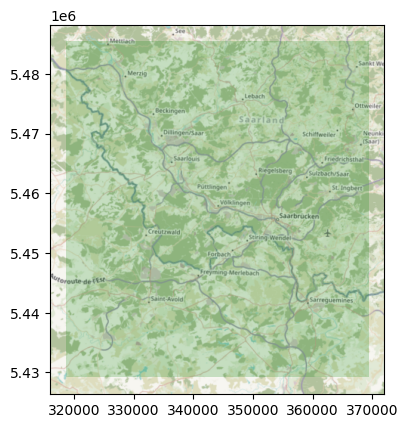

In [14]:
ax = plt.gca()
gpd.GeoSeries(polygon).plot(ax=ax, color='green', alpha=0.2)
cx.add_basemap(ax=ax, crs = 'EPSG:32632', attribution='')

In [17]:
n_div_per_side = 2

In [83]:
def divide_polygon(bbox, n):
    # Divide the x-axis and y-axis into n equivalent spaces
    x_divisions = np.linspace(bbox[0], bbox[2], n + 1)
    y_divisions = np.linspace(bbox[1], bbox[3], n + 1)
    polygons = []
    for x_i in range(n):
        for y_i in range(n):
            new_poly = Polygon([(x_divisions[x_i], y_divisions[y_i]),
                                (x_divisions[x_i + 1], y_divisions[y_i]),
                                (x_divisions[x_i + 1], y_divisions[y_i + 1]),
                                (x_divisions[x_i], y_divisions[y_i + 1])
                               ])
            polygons.append(new_poly)

    return polygons

In [276]:
polygons = divide_polygon(bbox, 2)

In [277]:
polygons

[<POLYGON ((318601.284 5429122.332, 343983.969 5429122.332, 343983.969 545727...>,
 <POLYGON ((318601.284 5457270.863, 343983.969 5457270.863, 343983.969 548541...>,
 <POLYGON ((343983.969 5429122.332, 369366.654 5429122.332, 369366.654 545727...>,
 <POLYGON ((343983.969 5457270.863, 369366.654 5457270.863, 369366.654 548541...>]

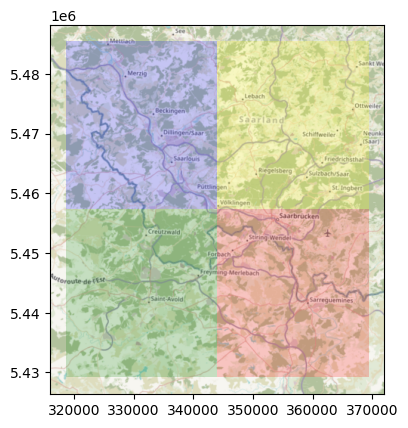

In [278]:
plt.figure()
ax = plt.gca()
gpd.GeoSeries(polygons[0]).plot(ax=ax, color='green', alpha=0.2)
gpd.GeoSeries(polygons[1]).plot(ax=ax, color='blue', alpha=0.2)
gpd.GeoSeries(polygons[2]).plot(ax=ax, color='red', alpha=0.2)
gpd.GeoSeries(polygons[3]).plot(ax=ax, color='yellow', alpha=0.2)
cx.add_basemap(ax=ax, crs = 'EPSG:32632', attribution='')

In [279]:
# Create GeoDataFrames from GeoSeries
polygons_gdf = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:32632")
points_gdf = gpd.GeoDataFrame(geometry=insar_geometry_conv, crs="EPSG:32632")

# Perform spatial join
result = gpd.sjoin(points_gdf, polygons_gdf, how="left", predicate="covered_by")

In [280]:
result

geometry  index_right
0       POINT (318601.284 5430544.525)            0
1       POINT (318669.412 5430531.262)            0
2       POINT (318643.924 5430550.347)            0
3       POINT (318781.792 5430522.922)            0
4       POINT (318826.806 5430513.812)            0
...                                ...          ...
218632  POINT (367377.602 5484572.421)            3
218633  POINT (367402.494 5484567.572)            3
218634  POINT (367442.580 5484573.811)            3
218635  POINT (367387.849 5484598.904)            3
218636  POINT (367176.109 5484654.974)            3

[218637 rows x 2 columns]

In [89]:
result.index_right.value_counts()

3    72954
2    58821
1    47776
0    39086
Name: index_right, dtype: int64

In [101]:
max_n_points = result.index_right.value_counts().max()

In [90]:
assert result.shape[0] == insar_geometry_conv.shape[0]

In [94]:
edge_weights = compute_edge_weights(edge_distances, weight_scaling, dtype=dtype)

In [95]:
insar_y, insar_mask, insar_ts, insar_delta_ts, insar_first_day, insar_last_day = InSAR.get_data_for_graph(insar_df, dtype=dtype, device=device)

In [214]:
gnss_y, gnss_mask, gnss_ts, gnss_delta_ts = GNSS.get_data_for_graph(gnss_df, insar_first_day, insar_last_day, dtype=dtype, device=device)

100%|██████████| 39/39 [00:00<00:00, 228.49it/s]


In [96]:
print("insar_y:", insar_y.shape)
print("insar_mask:", insar_mask.shape)
print("insar_ts:", insar_ts.shape)
print("insar_delta_ts:", insar_delta_ts.shape)

insar_y: torch.Size([218637, 1549, 1])
insar_mask: torch.Size([218637, 1549])
insar_ts: torch.Size([1549])
insar_delta_ts: torch.Size([218637, 1549])


In [119]:
from readers.util import node_t_deltas

In [113]:
def add_rows_until_max(original_tensor, n_rows):
    rows_to_add = max(0, n_rows - original_tensor.size(0))

    # Create a tensor with zeros to add
    zeros_to_add_shape = (rows_to_add,) + original_tensor.size()[1:]  # Keep the dimensions from 2 onwards
    zeros_to_add = torch.zeros(zeros_to_add_shape, dtype=original_tensor.dtype, device=original_tensor.device)

    # Concatenate the original tensor with zeros
    result_tensor = torch.cat((original_tensor, zeros_to_add), dim=0)
    return result_tensor

In [132]:
gnss_start = insar_df.shape[0]

In [230]:
graphs = []
for chosen_polygon in tqdm(range(len(polygons_gdf))):
    chosen_points = result.index_right == chosen_polygon
    n_points_in_polygon = result.index_right.value_counts()[chosen_polygon]
    
    chosen_insar_y = insar_y[chosen_points]
    chosen_insar_mask = insar_mask[chosen_points]
    chosen_insar_delta_ts = insar_delta_ts[chosen_points]
    
    expanded_y = add_rows_until_max(chosen_insar_y, max_n_points)
    expanded_mask = add_rows_until_max(chosen_insar_mask, max_n_points)
    expanded_delta_ts = node_t_deltas(insar_ts.unsqueeze(0),
             expanded_mask.unsqueeze(0).transpose(1,2)).squeeze(0).transpose(0,1)
    
    assert (chosen_insar_delta_ts == expanded_delta_ts[:n_points_in_polygon]).all()
    
    chosen_points_idx = np.nonzero(chosen_points.values)[0]
    keep_edges_bool = torch.logical_and(
        torch.isin(edges[1], torch.LongTensor(chosen_points_idx)), # the ones that finish at some point in the chose
        torch.logical_or( # the ones that start at some point in the chosen or in a GNSS station
            torch.isin(edges[0], torch.LongTensor(chosen_points_idx)),
            edges[0] > gnss_start
        ))
    kept_edges = edges[:,keep_edges_bool]
    renamed_edges = torch.searchsorted(torch.LongTensor(chosen_points_idx), kept_edges)
    
    renamed_edges[renamed_edges == n_points_in_polygon] = kept_edges[renamed_edges == n_points_in_polygon] - gnss_start + max_n_points
    
    y = torch.cat([expanded_y, gnss_y], dim=0)
    mask = torch.cat([expanded_mask, gnss_mask], dim=0)
    delta_ts = torch.cat([expanded_delta_ts, gnss_delta_ts], dim=0)
    ts = insar_ts
    selected_edge_weights = edge_weights[keep_edges_bool]
    graph = ptg.data.Data(edge_index=renamed_edges,
                         edge_attr=selected_edge_weights, 
                         y=y,
                         mask=mask,
                         t=ts.unsqueeze(0),
                         delta_t=delta_ts,
                         hop_mask=mask, # not sure 
                         update_delta_t=delta_ts,
                         num_nodes=max_n_points + gnss_y.shape[0])
    graphs.append(graph)

100%|██████████| 4/4 [00:35<00:00,  8.86s/it]


In [231]:
graphs[0]

Data(edge_index=[2, 429118], edge_attr=[429118, 1], y=[72993, 1549, 1], mask=[72993, 1549], t=[1, 1549], delta_t=[72993, 1549], hop_mask=[72993, 1549], update_delta_t=[72993, 1549], num_nodes=72993)

In [232]:
graphs[1]

Data(edge_index=[2, 524340], edge_attr=[524340, 1], y=[72993, 1549, 1], mask=[72993, 1549], t=[1, 1549], delta_t=[72993, 1549], hop_mask=[72993, 1549], update_delta_t=[72993, 1549], num_nodes=72993)

In [233]:
graphs[2]

Data(edge_index=[2, 645851], edge_attr=[645851, 1], y=[72993, 1549, 1], mask=[72993, 1549], t=[1, 1549], delta_t=[72993, 1549], hop_mask=[72993, 1549], update_delta_t=[72993, 1549], num_nodes=72993)

In [234]:
graphs[3]

Data(edge_index=[2, 800842], edge_attr=[800842, 1], y=[72993, 1549, 1], mask=[72993, 1549], t=[1, 1549], delta_t=[72993, 1549], hop_mask=[72993, 1549], update_delta_t=[72993, 1549], num_nodes=72993)

In [235]:
graphs[0].edge_index

tensor([[    2,     5,     1,  ..., 39084, 39083, 72965],
        [    0,     0,     0,  ..., 39085, 39085, 39085]])

In [236]:
graphs[1].edge_index

tensor([[    2,     3,     1,  ..., 47763, 47754, 72967],
        [    0,     0,     0,  ..., 47775, 47775, 47775]])

In [237]:
graphs[0].mask

tensor([[1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [238]:
edges

tensor([[     2,      5,      1,  ..., 218621, 218601, 218649],
        [     0,      0,      0,  ..., 218636, 218636, 218636]])

# some consistency checks

In [242]:
result.iloc[102774]

geometry       POINT (336779.90545215347 5460044.688168679)
index_right                                               1
Name: 102774, dtype: object

In [248]:
(result[result.index_right==1].index < 102774).sum() # 102774 is node 6343 in graph[1]

6343

In [251]:
edges[:,edges[1,:] == 102774]

tensor([[102782, 102553, 102784, 102554, 102446, 102443, 102549, 103019, 102302,
         102448, 218648],
        [102774, 102774, 102774, 102774, 102774, 102774, 102774, 102774, 102774,
         102774, 102774]])

In [253]:
graphs[1].edge_index[:, graphs[1].edge_index[1,:] == 6343]

tensor([[ 6345,  6268,  6346,  6269,  6222,  6221,  6266,  6432,  6169,  6223,
         72965],
        [ 6343,  6343,  6343,  6343,  6343,  6343,  6343,  6343,  6343,  6343,
          6343]])

In [255]:
218648 - gnss_start + max_n_points # correct gnss station

72965

In [269]:
(torch.cat([insar_y, gnss_y], dim=0)[218648] == graphs[1].y[72965]).all()

tensor(True)

In [268]:
(insar_y[102774] ==  graphs[1].y[6343]).all()

tensor(True)

In [262]:
insar_nn_ind[102774][:10]

array([102782, 102553, 102784, 102554, 102446, 102443, 102549, 103019,
       102302, 102448])

In [270]:
(result[result.index_right==1].index < 102782).sum()

6345

In [271]:
(result[result.index_right==1].index < 102448).sum()

6223

In [97]:
chosen_points = result.index_right == 0

In [105]:
chosen_insar_y = insar_y[chosen_points]
chosen_insar_mask = insar_mask[chosen_points]
chosen_insar_delta_ts = insar_delta_ts[chosen_points]

In [106]:
chosen_insar_delta_ts.shape

torch.Size([39086, 1549])

In [120]:
expanded_y = add_rows_until_max(chosen_insar_y, max_n_points)
expanded_mask = add_rows_until_max(chosen_insar_mask, max_n_points)

In [121]:
expanded_delta_ts = node_t_deltas(insar_ts.unsqueeze(0),
             expanded_mask.unsqueeze(0).transpose(1,2)).squeeze(0).transpose(0,1)

In [123]:
expanded_delta_ts

tensor([[0.0000e+00, 6.4599e-04, 1.2920e-03,  ..., 6.4600e-03, 7.1059e-03,
         7.7519e-03],
        [0.0000e+00, 6.4599e-04, 1.2920e-03,  ..., 6.4600e-03, 7.1059e-03,
         7.7519e-03],
        [0.0000e+00, 6.4599e-04, 1.2920e-03,  ..., 6.4600e-03, 7.1059e-03,
         7.7519e-03],
        ...,
        [0.0000e+00, 6.4599e-04, 1.2920e-03,  ..., 9.9871e-01, 9.9935e-01,
         1.0000e+00],
        [0.0000e+00, 6.4599e-04, 1.2920e-03,  ..., 9.9871e-01, 9.9935e-01,
         1.0000e+00],
        [0.0000e+00, 6.4599e-04, 1.2920e-03,  ..., 9.9871e-01, 9.9935e-01,
         1.0000e+00]])

In [126]:
chosen_insar_delta_ts.shape

torch.Size([39086, 1549])

In [128]:
(chosen_insar_delta_ts == expanded_delta_ts[:39086]).all()

tensor(True)

In [146]:
chosen_points

0          True
1          True
2          True
3          True
4          True
          ...  
218632    False
218633    False
218634    False
218635    False
218636    False
Name: index_right, Length: 218637, dtype: bool

In [154]:
chosen_points_idx = np.nonzero(chosen_points.values)[0]

In [156]:
edges[0]

tensor([     2,      5,      1,  ..., 218621, 218601, 218649])

In [162]:
keep_edges_bool = torch.logical_and(
    torch.isin(edges[1], torch.LongTensor(chosen_points_idx)), # the ones that finish at some point in the chose
    torch.logical_or(
        torch.isin(edges[0], torch.LongTensor(chosen_points_idx)),
        edges[0] > gnss_start
    ))
    

In [166]:
kept_edges = edges[:,keep_edges_bool]

In [173]:
chosen_points_idx

array([    0,     1,     2, ..., 89460, 89461, 89725])

In [177]:
kept_edges[:,kept_edges[1,:] == 89725] # some nodes may not have 10 incoming insar points but don't care about it for now

tensor([[ 89461,  89460, 218648],
        [ 89725,  89725,  89725]])

In [178]:
insar_nn_ind[89725][:10]

array([89856, 90250, 89851, 89461, 90249, 89853, 90630, 90631, 89460,
       90629])

# now we need to "rename" the nodes in the edges as the indices are not correct

In [180]:
kept_edges

tensor([[     2,      5,      1,  ...,  89461,  89460, 218648],
        [     0,      0,      0,  ...,  89725,  89725,  89725]])

In [181]:
chosen_points_idx

array([    0,     1,     2, ..., 89460, 89461, 89725])

In [186]:
insar_renamed = torch.searchsorted(torch.LongTensor(chosen_points_idx), kept_edges)

In [193]:
result.index_right.value_counts().loc[0]

39086

In [196]:
insar_renamed[insar_renamed == result.index_right.value_counts()[0]] = kept_edges[insar_renamed == result.index_right.value_counts()[0]] - gnss_start + max_n_points

In [197]:
insar_renamed

tensor([[    2,     5,     1,  ..., 39084, 39083, 72965],
        [    0,     0,     0,  ..., 39085, 39085, 39085]])

In [211]:
(insar_renamed == 72965).sum()

tensor(22083)

In [209]:
(torch.logical_and(edges[0,:] == 218648, torch.isin(edges[1], torch.LongTensor(chosen_points_idx)))).sum()

tensor(22083)